In [1]:
from models_new_test.model_tex_val_1 import BasicModel
from models_new_test.decoder_tex_white import ReconstructionLayer
# from models_new_test.decoder_tex import ReconstructionLayer
import yaml
from datasets.utils import createDataLoader
import matplotlib.pyplot as plt
from models_new_test.basic_loss import ArcFaceLoss
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import os.path as osp
from tqdm.notebook import tqdm
import cv2 as cv
import skimage.metrics as metrics
import time

In [2]:
from models_new_test.detect_net import Decoder

In [3]:
config = yaml.load(open('./models_new_test/config_with_gl.yml'), Loader=yaml.FullLoader)
model_config, train_config = config['model'], config['train']
model = BasicModel(model_config,\
                   is_continue=True,\
                   continue_path='./models_new_test/checkpoints/ckp_0120_percep_epoch_6.pt')
model.eval()                   
# model = BasicModel(model_config,\
#                    is_continue=True,\
#                    continue_path='./models_new_test/checkpoints/ckp_0113_without_mask_epoch_8.pt')
# model.eval()

initialize network with kaiming
initialize network with kaiming
initialize network with kaiming
initialize network with kaiming


In [4]:
name = 'extra_pengpai'
dl = createDataLoader(name, split='uv', shuffle=False, batch_size=1)
if not osp.isdir('../eval_data/results/{}'.format(name)):
    os.makedirs('../eval_data/results/{}'.format(name))

In [5]:
rerender = ReconstructionLayer('./models_new_test/model_config.json').cuda()
# loss = ArcFaceLoss().cuda()

param
detail_tex
detail_light

In [6]:
test_light = 0.7 * np.asarray([[1.326219983113404, 1.323056679344121, 1.3283157735367373],\
                         [0.7668396324904548, 0.7668396324904548, 0.7668396324904548],\
                         [-0.029462177779507496, -0.029462177779507496, -0.029462177779507496],\
                         [-0.26709178985775267, -0.26709178985775267, -0.26709178985775267],\
                         [-0.04845251308196257, -0.04845251308196257, -0.04845251308196257],\
                         [0.07521658449982196, 0.07521658449982196, 0.07521658449982196],\
                         [-0.09521499137891894, -0.09521499137891894, -0.09521499137891894],\
                         [-0.028509181588036392, -0.02523183186345062, -0.028509181588036392],\
                         [0.24027236012578904, 0.24027236012578904, 0.24027236012578904]]).reshape(9,3).transpose(1,0).reshape(-1)

test_light = 0.7 * np.asarray([[1.147301931003462, 1.274630535189885, 0.8055790328315944], [0.13113888125762585, 0.4095158416184328, 0.2300108604968405], [-0.15250547311616258, -0.3898535530658499, -0.1961145746992123], [-0.33987940040540493, -0.7060284234364206, -0.39222196504876017], [-0.34960314336028525, -0.8015946218908213, -0.3645561932874682], [-0.06089179045822735, -0.1730322158070536, 0.007054494367386955], [0.4529033288186928, 0.5218044376392427, 0.3360996454843721], [0.05626446594072994, 0.32356477806395945, 0.03545781659719712], [0.6495178621157901, 0.8000487125908268, 0.4227117919287461]]).transpose(1,0).reshape(-1)
# x = np.asarray([[0.8252622651464068, 1.0196953575464247, 1.1801418740417589], [0.04638447281353189, 0.21455988406397425, 0.2309877084835137], [-0.11176825132052828, -0.32671907200851386, -0.37603009186347197], [-0.021982689671243994, -0.012971954347110013, -0.0380499998669174], [0.11174370562234008, 0.08231909769166151, 0.13996920056281023], [0.06900463611824155, -0.05646859718774846, 0.023756181503724647], [0.046791141977565974, 0.02897426195046808, -0.014634144138012162], [-0.28757978279507007, -0.34748339674992906, -0.39391886847056173], [0.33858548530222526, 0.46172926275501547, 0.5866602323108406]])
# sign = (x[:,1] > 0.0).astype(np.float32)
# y = np.linalg.norm(x, axis=1) * sign
# test_light = y[:,None].repeat(3, axis=-1).transpose(1,0).reshape(-1)

In [7]:
from models_new_test.interface import readConfig, MatFile
reader = MatFile()
if reader('./BFM/BFM_model_front.mat') == 0:
    tris = getattr(reader, 'tri').astype(np.int)
f_lines = []
for tri in tris:
    f_lines.append('f ' + ' '.join([str(v) for v in tri]) + '\n')

/data/yangmx/anaconda3/envs/torch150/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [8]:
detail_tex_list = []
detail_tex_light_list = []
shape_rt_list = []
fn_list = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dl)):
        model.set_input(data)
        model.forward()
        detail_tex_list.append(model.detail_tex_face_illu.detach().cpu().numpy())
        detail_tex_light_list.append(model.detail_illu.detach().cpu().numpy())
        shape_rt_list.append(model.shape_rt.detach().cpu().numpy())
        fn_list.append(data['fn'])

0it [00:00, ?it/s]

In [9]:
def writeObj(fn, shape, tex, f_lines):
    v_lines = []
    shape = shape.squeeze()
    tex = tex.squeeze()
    for v, t in zip(shape, tex):
        v_lines.append('v ' + ' '.join([str(coord) for coord in v]) + ' ' + ' '.join([str(rgb) for rgb in t.clip(0,1)]) + '\n')
    with open(fn, 'w') as fh:
        fh.writelines(v_lines + f_lines)

In [10]:
root = './obj_results_illu'
if not osp.isdir(root):
    os.makedirs(root)
for i, fn in tqdm(enumerate(fn_list)):
    writeObj(osp.join(root, fn[0]+'.obj'), shape_rt_list[i], detail_tex_list[i], f_lines)

0it [00:00, ?it/s]

In [11]:
uv_mask = np.load('./Data/uv_mask_256.npy')[...,None]
param_list = []
detail_tex_list = []
detail_light_list = []
img_gt_list = []
tex_gt_list = []
val_list = []
detail_tex_map_list = []
tex_gt_list = []
gen_mask_list = []
light_list = []
test_list = []
coarse_list = []
org_tex_list = []
coarse_tex_list = []
fn_list = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dl)):
        mask = data['gen_mask'].permute(0,3,1,2)
#         data['param'][0,224:227] = torch.from_numpy(np.asarray([np.pi/20.0,-np.pi/15,0])).to(data['param'][0,224:227].device)
#         data['param'][0,229] = 0.0
#         data['param'][0,224:227] = torch.from_numpy(np.asarray([0,0,0])).to(data['param'].device)
#         data['param'][0,227:227+27] = torch.from_numpy(test_light).to(data['param'].device)
        tex_gt_list.append(data['im_tex'])
#         data['coarse_tex'] = torch.as_tensor(uv_mask) * torch.ones_like(data['coarse_tex']).to(data['coarse_tex'].device)
        gen_mask_list.append(mask.detach().cpu().numpy())
        model.set_input(data)
        model.forward()
        param_list.append(data['param'])
        coarse_tex_list.append(model.coarse_tex_map.detach().cpu())
        org_tex_list.append(model.im_tex.detach().cpu())
        detail_tex_list.append(model.detail_tex.detach().cpu())
        detail_light_list.append(model.detail_light.detach().cpu())
        detail_tex_map_list.append(model.detail_tex_map.detach().cpu())
        img_gt_list.append(data['image'].permute(0,3,1,2).detach().cpu())
        coarse_list.append(model.coarse_face_image_update.detach().cpu())
        test_list.append(model.detail_face_image_update.detach().cpu())
        val_list.append(model.detail_face_image.detach().cpu())
        light_list.append(model.light.detach().cpu())
        fn_list.append(data['fn'][0])

0it [00:00, ?it/s]

AttributeError: 'BasicModel' object has no attribute 'coarse_face_image_update'

In [ ]:
def process(img, mask=None):
    alpha = img[...,-1]
    if mask is not None:
        alpha[mask[:,0,...].squeeze() == 1.0] = 1.0
    img = img[...,:-1]
    img[alpha==0,:] = 1.0
    return img

In [ ]:
def process_tex(tex):
    tex = tex * uv_mask
    tex[uv_mask.squeeze()==0.0,:] = 1.0
    return tex

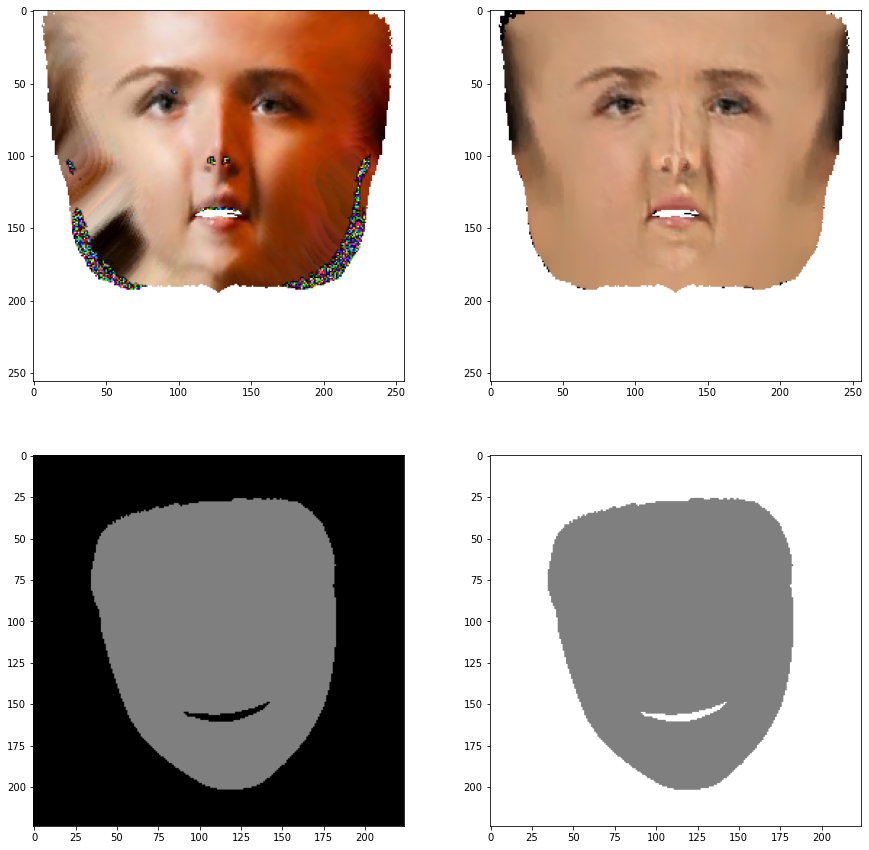

In [ ]:
folder = 'relight'
if not osp.isdir(folder):
    os.makedirs(folder)
save = True
fig, ax = plt.subplots(2,2,figsize=(15,15))
# for num in range(len(img_gt_list)):
num = 7
#     n = 1
fn = fn_list[num]
im_tex = process_tex(tex_gt_list[num].detach().cpu().numpy().squeeze().clip(0,1))
detail_tex = process_tex(detail_tex_map_list[num].detach().cpu().numpy().squeeze().transpose(1,2,0).clip(0,1))
im = (img_gt_list[num].detach().cpu().numpy().squeeze().transpose(1,2,0)).clip(0,1)
overlay = coarse_list[num].detach().cpu().numpy().squeeze().transpose(1,2,0).clip(0,1)[...,:-1] * gen_mask_list[num].squeeze().transpose(1,2,0) +\
              (1 - gen_mask_list[num].squeeze().transpose(1,2,0)) * img_gt_list[num].detach().cpu().numpy().squeeze().transpose(1,2,0).clip(0,1)
render = coarse_list[num].detach().cpu().numpy().squeeze().transpose(1,2,0).clip(0,1)
detail_render = val_list[num].detach().cpu().numpy().squeeze().transpose(1,2,0).clip(0,1)[...,:-1]
ax[0,0].imshow(im_tex)
ax[0,1].imshow(detail_tex)
ax[1,0].imshow(detail_render)
# ax[1,0].imshow(val_list[num].detach().cpu().numpy().squeeze().clip(0,1).transpose(1,2,0)[...,:3])
ax[1,1].imshow(render)
if save:
#     plt.imsave('./{}/imgtex_{}.jpg'.format(folder, fn), im_tex)
    plt.imsave('./uv_detail_map.jpg', detail_tex)
#     plt.imsave('./{}/img_{}.jpg'.format(folder, fn), im)
#     plt.imsave('./{}/overlay_{}.jpg'.format(folder, fn), overlay)
#     plt.imsave('./{}/render_{}.jpg'.format(folder, fn), render)
#       plt.imsave('./{}/light_{}_{}.jpg'.format(folder, fn, n), light_list[num].detach().cpu().numpy().squeeze().clip(0,1)[...,:-1] * gen_mask_list[num].squeeze().transpose(1,2,0) +\
#               (1 - gen_mask_list[num].squeeze().transpose(1,2,0)) * np.ones_like(img_gt_list[num].detach().cpu().numpy().squeeze().transpose(1,2,0).clip(0,1)))

In [ ]:
import os
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import sys
sys.path.append('/data/yangmx/Code/jupyter/DetailRecPipeline/coarse_reconstruct')
from models_new_test.decoder_basic import ReconstructionLayer, BFM09
from face3d.face3d import mesh
from models.interface import MatFile, readConfig
import torch
import os.path as osp
import os

In [ ]:
class UVGen:
    
    # Return uv-coordinate([0,1])
    @staticmethod
    def loadAndParameterization(uv_mat_path, select_id_path):
        uv_mat_reader = MatFile()
        select_id_reader = MatFile()
        if uv_mat_reader(uv_mat_path) == 0:
            uv = getattr(uv_mat_reader, 'UV')
        if select_id_reader(select_id_path) == 0:
            select_id = getattr(select_id_reader, 'select_id') - 1
        return uv[select_id].squeeze()
    
    # Turn uv-coordinates to uv-image coordinates
    @staticmethod
    def process_uv(uv_coords, uv_size=256):
        uv_coords[:,0] = uv_coords[:,0] * (uv_size-1)
        uv_coords[:,1] = uv_coords[:,1] * (uv_size-1)
        uv_coords[:,1] = (uv_size-1) - uv_coords[:,1]
        return np.concatenate([uv_coords, np.zeros([uv_coords.shape[0],1])], axis=-1)
    
    def __init__(self, config):
        super().__init__()
        self.config = readConfig(config)
        self.uv_coord = self.loadAndParameterization(self.config['uv_mat_path'], self.config['select_id_path'])
        self.uv_coord_3d = self.process_uv(self.uv_coord, self.config['uv_size'])
        self.proxy_model = BFM09(self.config['proxy_path'])
        
    # attr : [35709,?]
    def call(self, attr):
        uv_image = mesh.render.render_colors(vertices=self.uv_coord_3d,
                                             triangles=self.proxy_model.triangles.cpu().numpy(),
                                             colors=attr,h=self.config['uv_size'], w=self.config['uv_size'], c = 3)
        return uv_image
    
    def __call__(self, attr):
        return self.call(attr)

In [ ]:
uvgen = UVGen('../coarse_reconstruct/models/uv_config.json')

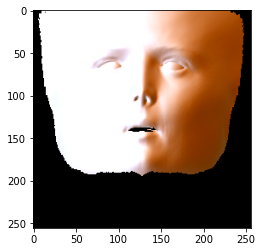

In [ ]:
plt.imshow(uvgen(light_list[7].squeeze().detach().cpu().numpy()).clip(0,1))
plt.imsave('uv_light_map.jpg', uvgen(light_list[7].squeeze().detach().cpu().numpy()).clip(0,1))

In [ ]:
n = 122
dl = detail_light_list[4].cuda()
odl = detail_light_list[n].cuda()
im_light = img_gt_list[4].squeeze().cpu().numpy().clip(0,1).transpose(1,2,0)
im_albedo = img_gt_list[n].squeeze().cpu().numpy().clip(0,1).transpose(1,2,0)
param = param_list[n].cuda()
detail_albedo = detail_tex_list[n].cuda()
result = rerender(param, detail_albedo, dl)
other_render = result[-2].squeeze().cpu().numpy().clip(0,1)
result = rerender(param, detail_albedo, odl)
org_render = result[-3].squeeze().cpu().numpy().clip(0,1)
# plt.imsave('./mid_results/im_light.jpg', im_light)
# plt.imsave('./mid_results/other_render.jpg', other_render)
plt.imsave('./independ/org_render_gt_{}.jpg'.format(n), org_render)
# plt.imsave('./independ/img_{}.jpg'.format(n), im_albedo)
# plt.imsave('./independ/im_tex_{}.jpg'.format(n), org_tex_list[n].detach().cpu().numpy().squeeze().transpose(1,2,0).clip(0,1))
# plt.imshow(other_render)
# plt.imshow(im_albedo)
# plt.imshow(org_render)

IndexError: list index out of range

In [ ]:
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

In [ ]:
verts = uvgen.proxy_model.shape_mean[None,...].reshape(35709,3)
faces = uvgen.proxy_model.triangles
tex = TexturesVertex(verts_features=torch.ones_like(verts).cuda()[None,...])
mesh = Meshes(
    verts=[verts.cuda()],   
    faces=[faces.cuda()],
    textures=tex
)

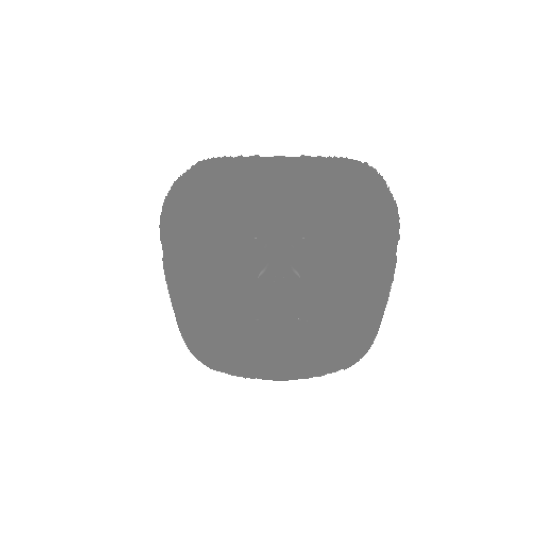

In [ ]:
device = 'cuda:0'
R, T = look_at_view_transform(2.7,0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 10, -10]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");